In [271]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

%matplotlib inline

plt.rcParams.update({'font.size': 20})
root_directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/'

##### Load:
- individual anatomy
- functional mean
- warped PB roi

# Load Anatomy


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 229.22 ms


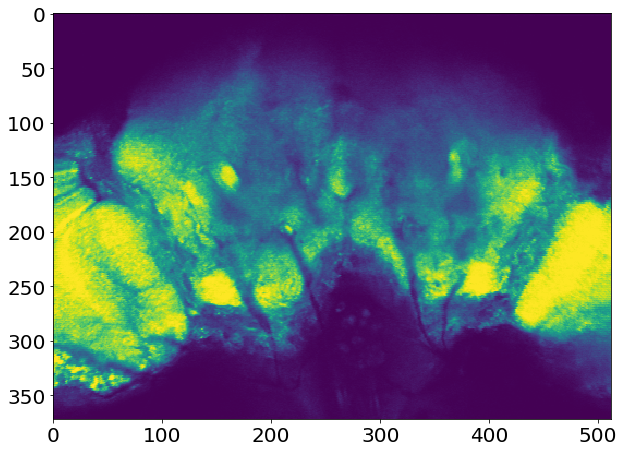

In [4]:
file = os.path.join(root_directory,'fly_21','anat_0','anatomy.nii')
anatomy = bbb.load_numpy_brain(file)

anatomy = ants.from_numpy(anatomy)
anatomy_xml = os.path.join(root_directory, 'fly_21', 'anat_0', 'anatomy.xml')
anatomy.set_spacing(bbb.get_resolution(anatomy_xml))

plt.figure(figsize=(10,10))
ax = plt.subplot()
ax.imshow(anatomy.numpy()[:,:,90].T)

# Load functional mean


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 73.26 ms


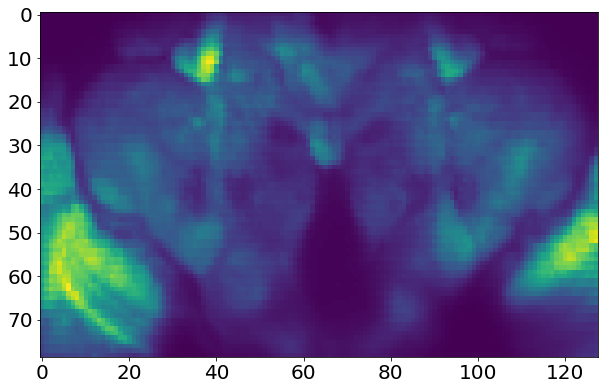

In [5]:
file = os.path.join(root_directory,'fly_21','func_0','motcorr','meanbrain_red.nii')
func = bbb.load_numpy_brain(file)

func = ants.from_numpy(func)
func_xml = os.path.join(root_directory, 'fly_21', 'func_0', 'imaging','functional.xml')
func.set_spacing(bbb.get_resolution(func_xml))

plt.figure(figsize=(10,10))
ax = plt.subplot()
ax.imshow(func.numpy()[:,:,30].T)

# Load warped ROIs


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 895.70 ms

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 885.38 ms


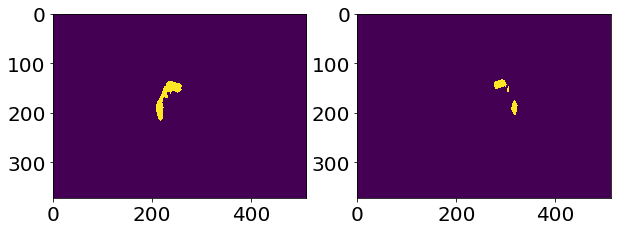

In [7]:
file = os.path.join(root_directory,'20191204_anatomy_collection','20191210','PB_L_warped.nii.gz')
roi_L = bbb.load_numpy_brain(file)
roi_L = ants.from_numpy(roi_L)
anatomy_xml = os.path.join(root_directory, 'fly_25', 'anat_0', 'anatomy.xml')
roi_L.set_spacing(bbb.get_resolution(anatomy_xml))

file = os.path.join(root_directory,'20191204_anatomy_collection','20191210','PB_R_warped.nii.gz')
roi_R = bbb.load_numpy_brain(file)
roi_R = ants.from_numpy(roi_R)
anatomy_xml = os.path.join(root_directory, 'fly_25', 'anat_0', 'anatomy.xml')
roi_R.set_spacing(bbb.get_resolution(anatomy_xml))

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(roi_L.numpy()[:,:,70].T)
plt.subplot(122)
plt.imshow(roi_R.numpy()[:,:,70].T)

# Warp anat to func

In [8]:
t0 = time.time()
anat2func = ants.registration(func,anatomy,type_of_transform='Affine')
print('COMPLETE. Duration: {:0.0f} sec'.format(time.time()-t0))

COMPLETE. Duration: 7 sec


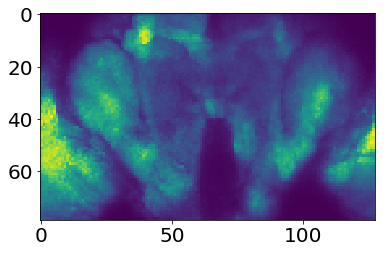

In [9]:
plt.imshow(anat2func['warpedmovout'].numpy()[:,:,30].T)

# Apply warp transform to ROIs

In [10]:
roiL2func = ants.apply_transforms(fixed = func,
                                 moving = roi_L,
                                 transformlist = anat2func['fwdtransforms'],
                                 interpolator='genericLabel')

roiR2func = ants.apply_transforms(fixed = func,
                                 moving = roi_R,
                                 transformlist = anat2func['fwdtransforms'],
                                 interpolator='genericLabel')

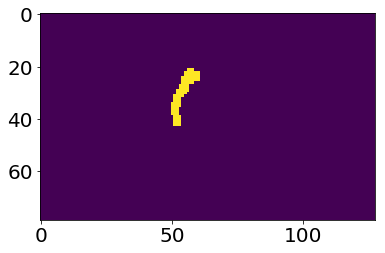

In [17]:
plt.imshow(roiL2func.numpy()[:,:,11].T)

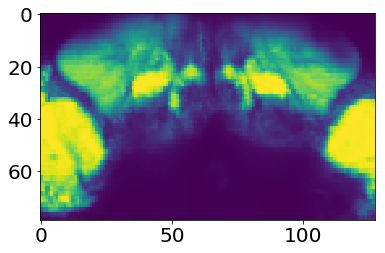

In [16]:
plt.imshow(func.numpy()[:,:,11].T)
#plt.imshow(roi2func.numpy()[:,:,13].T)

# Load functional data

In [18]:
file = os.path.join(root_directory,'fly_21','func_0','motcorr','motcorr_green.nii')
data = bbb.load_numpy_brain(file)
data.shape


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 16.40 sec


(128, 79, 53, 4370)

# Get mean signal from PB across time

In [ ]:
# since we are dealing with raw signal (not z-scored), we need to calculate df/f separately for each voxel?
# for each voxel, need its baseline, as defined by not walking
# then, subtract then divide by this scalar (different for each voxel). these vectors can then be averaged.

In [202]:
# Calculate qui_times below!
qui_times_idx = np.where(qui_times == 1)[0]

In [178]:
PB_R_points = np.asarray(np.where(roiR2func.numpy()==1))
PB_L_points = np.asarray(np.where(roiL2func.numpy()==1))

In [185]:
PB_R_data = data[PB_R_points[0,:],PB_R_points[1,:],PB_R_points[2,:],:]
PB_L_data = data[PB_L_points[0,:],PB_L_points[1,:],PB_L_points[2,:],:]

In [222]:
voxel_baselines_R = np.mean(PB_R_data[:,qui_times_idx],axis=1)
voxel_baselines_L = np.mean(PB_L_data[:,qui_times_idx],axis=1)

In [223]:
# calculate df/f for each voxel
PB_R_dff = (PB_R_data-voxel_baselines_R[:,np.newaxis])/voxel_baselines_R[:,np.newaxis]
PB_L_dff = (PB_L_data-voxel_baselines_L[:,np.newaxis])/voxel_baselines_L[:,np.newaxis]

In [458]:
# average over ROIs
PB_R_signal = np.mean(PB_R_dff,axis=0)
PB_L_signal = np.mean(PB_L_dff,axis=0)

In [420]:
# if NOT!! normalizing, run this one:
PB_R_signal = np.mean(PB_R_data,axis=0)
PB_L_signal = np.mean(PB_L_data,axis=0)

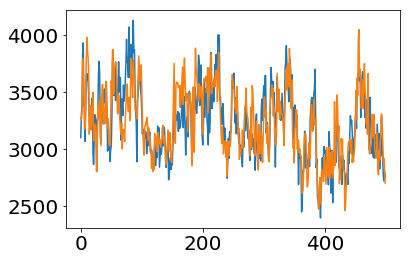

In [421]:
start = 3000
stop = 3500
plt.plot(PB_R_signal[start:stop])
plt.plot(PB_L_signal[start:stop])

# Load and process fictrac

In [19]:
directory = os.path.join(root_directory,'fly_21','func_0')
timestamps = bbb.load_timestamps(os.path.join(directory, 'imaging'))
fictrac = bbb.load_fictrac(os.path.join(directory, 'fictrac'))


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 1.13 sec

~~ load_fictrac ~~
load_fictrac done. Duration: 2.82 sec


In [20]:
def interp_fictrac(fictrac, behavior, fps, expt_len, timestamps):
    camera_rate = 1/fps * 1000 # camera frame rate in ms
    sphere_radius = 4.5e-3
    filter_window = 51
    
    x_original = np.arange(0,expt_len,camera_rate)
    
    if behavior == 'Y':
        dy = np.asarray(fictrac['dRotLabY'])
        fictrac_smoothed = savgol_filter(dy,filter_window,3) * sphere_radius * 50 * 100 * 10
    elif behavior == 'Z':
        dz = np.asarray(fictrac['dRotLabZ'])
        fictrac_smoothed = savgol_filter(dz,filter_window,3) * 180 / np.pi * 50
    else:
        print('invalid behavior')
    
    fictrac_interp_temp = interp1d(x_original, fictrac_smoothed, bounds_error = False)    
    fictrac_interp = fictrac_interp_temp(timestamps[:,25])

    # Replace Nans with zeros (for later code)
    np.nan_to_num(fictrac_interp, copy=False);
    
    return fictrac_interp

In [21]:
expt_len = 1000*30*60 #in ms
fps = 50 #of fictrac camera

fictracs = {}
for behavior in ['Y', 'Z']:
    fictracs[behavior] = interp_fictrac(fictrac, behavior, fps, expt_len, timestamps)

# Compare PB activity and behavior

(3000, 4000)

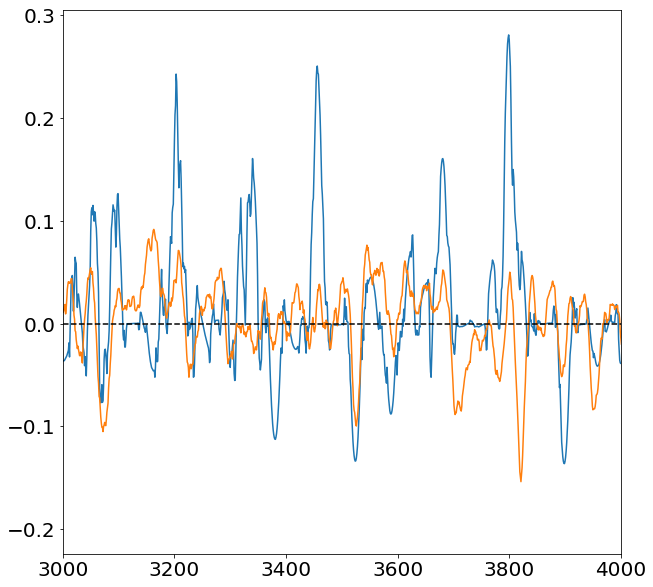

In [336]:
plt.figure(figsize=(10,10))

plt.plot(savgol_filter(fictracs['Z']/400,31,3))
#plt.plot(savgol_filter(PB_R_signal,31,3))
#plt.plot(savgol_filter(PB_L_signal,31,3))
plt.plot(savgol_filter(PB_L_signal,31,3)-savgol_filter(PB_R_signal,31,3))
plt.axhline(0,color='k',linestyle='--')
plt.xlim(3000,4000)

(3500, 3550)

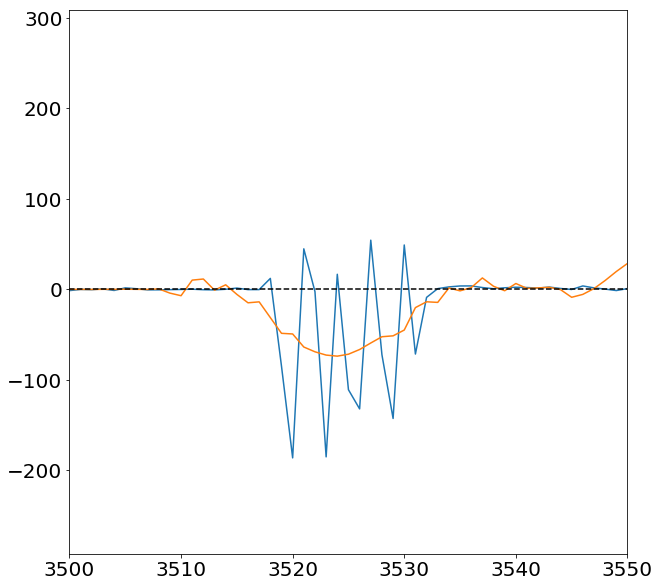

In [342]:
plt.figure(figsize=(10,10))

plt.plot(fictracs['Z'])
plt.plot(savgol_filter(fictracs['Z'],21,4))
#plt.plot(savgol_filter(PB_R_signal,31,3))
#plt.plot(savgol_filter(PB_L_signal,31,3))
#plt.plot(savgol_filter(PB_L_signal,31,3)-savgol_filter(PB_R_signal,31,3))
plt.axhline(0,color='k',linestyle='--')
plt.xlim(3500,3550)

Text(0.5, 0, 'time, sec')

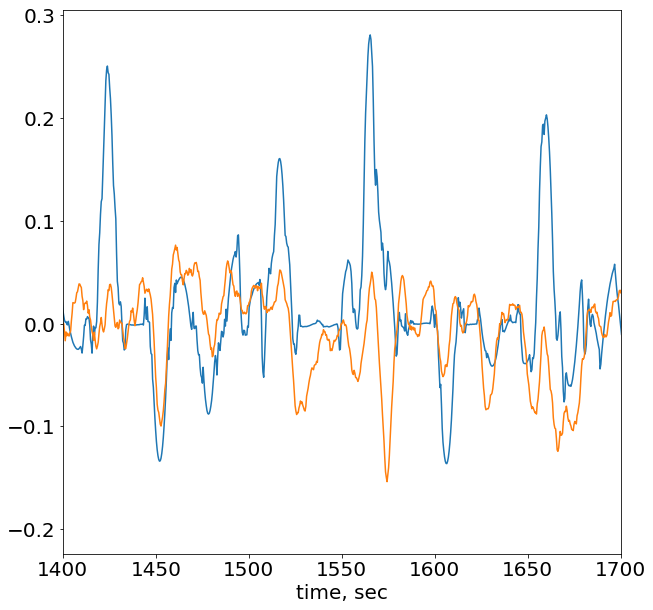

In [472]:
plt.figure(figsize=(10,10))

plt.plot(timestamps[:,25]/1000,savgol_filter(fictracs['Z']/400,31,3))
plt.plot(timestamps[:,25]/1000,savgol_filter(PB_L_signal,31,3)-savgol_filter(PB_R_signal,31,3))
plt.xlim(1400,1700)
plt.xlabel('time, sec')

(3000, 3800)

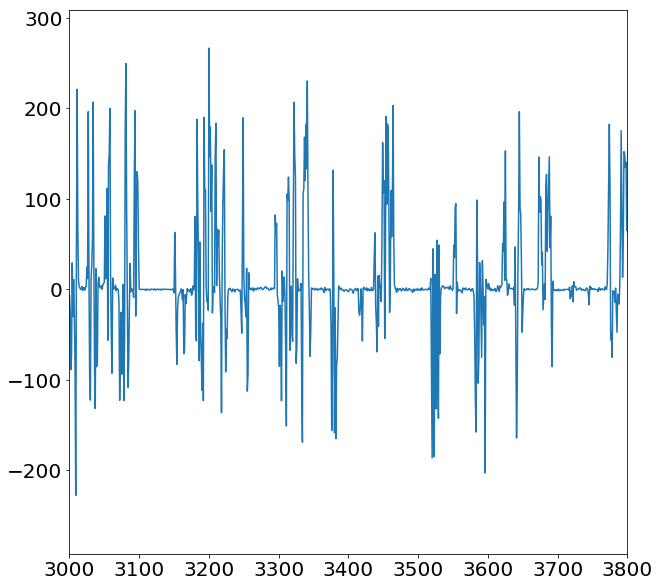

In [313]:
plt.figure(figsize=(10,10))
plt.plot(fictracs['Z'])
plt.xlim(3000,3800)

(3000, 4000)

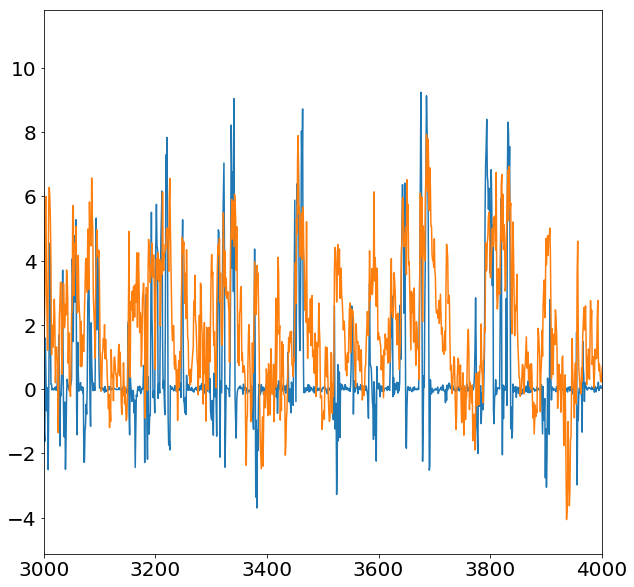

In [115]:
plt.figure(figsize=(10,10))
plt.plot(fictracs['Y'])
plt.plot((PB_signal*10)+2)
plt.xlim(3000,4000)

(3750, 3850)

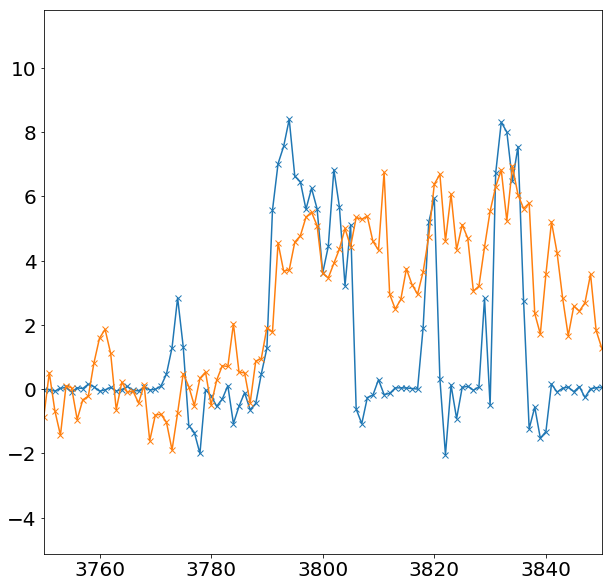

In [118]:
plt.figure(figsize=(10,10))
plt.plot(fictracs['Y'],marker='x')
plt.plot((PB_signal*10)+2,marker='x')
plt.xlim(3750,3850)

#### next steps:
- define behavior bouts
- call no movement neural activity baseline
- plot behavior-triggered PB activity
- Lets start with the most conservative bouts - actually, perhaps try 2 time scales - motifs and general arousal
- Lets also make imaging units into df/f!!!

In [345]:
def interp_fictrac(fictrac, fps, resolution, expt_len):
    behavior = 'dRotLabY'
    sigma = 0
    camera_rate = 1/fps * 1000 # camera frame rate in ms
    
    x_original = np.arange(0,expt_len,camera_rate)
    # 20ms resolution
    fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(fictrac[behavior]),25,3)
    #fictrac_smoothed = scipy.ndimage.filters.gaussian_filter(np.asarray(fictrac[behavior]),sigma=sigma)
    #fictrac_smoothed = np.abs(fictrac_smoothed)
    fictrac_interp_temp = interp1d(x_original, fictrac_smoothed, bounds_error = False)
    xnew = np.arange(0,expt_len,resolution) #0 to last time at subsample res
    fictrac_interp = fictrac_interp_temp(xnew)

    # Replace Nans with zeros (for later code)
    np.nan_to_num(fictrac_interp, copy=False);
    
    return fictrac_interp

resolution = 10 #desired resolution in ms
expt_len = 1000*30*60
fps = 50 #of fictrac camera
fictrac_interp = interp_fictrac(fictrac, fps, resolution, expt_len)
xnew = np.arange(0,expt_len,resolution)

In [405]:
###### CURRENT BEST METHOD ######

B_THRESHOLD = np.std(fictrac_interp)/4
ALIVE_TIME = 1000 # in ms
DEAD_TIME = 1000 # in ms

behavior = 'quiescent'
up_streak = 0
down_streak = 0
BOUTS = []
ALIVE_TIME = int(ALIVE_TIME/resolution)
DEAD_TIME = int(DEAD_TIME/resolution)

for i in range(len(fictrac_interp)):
    # If high behavior, reset down_streak, and add 1 to up_streak
    if fictrac_interp[i] > B_THRESHOLD:
        down_streak = 0
        up_streak += 1
    else:
        up_streak = 0
        down_streak += 1
        
    if behavior == 'quiescent':
        if up_streak >= ALIVE_TIME:
            behavior = 'moving'
            BOUTS.append({'start': i-ALIVE_TIME})
    elif behavior == 'moving':
        if down_streak >= DEAD_TIME:
            behavior = 'quiescent'
            BOUTS[-1]['end'] = i-DEAD_TIME
print('Found {} bouts'.format(len(BOUTS)))

Found 144 bouts


Text(0.5, 0, 'sec')

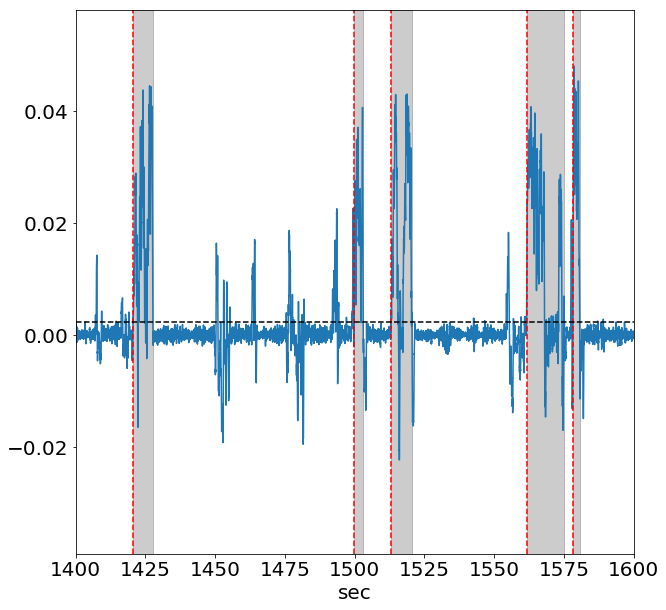

In [389]:
plt.figure(figsize=(10,10))

plt.plot(xnew/1000, fictrac_interp)
#plt.plot(xnew/1000,PB_signal_highres/10)

for bout in bouts:
    try:
        plt.axvspan(bout['start']/100, bout['end']/100, alpha=0.2, color='k')
        plt.axvline(bout['start']/100,color='r',linestyle='--')
    except:
        pass
    
plt.axhline(B_THRESHOLD,color='k',linestyle='--')
plt.xlim(1400,1600)
plt.xlabel('sec')
#plt.xlim(808,1000)

### Get the times of quiescence

In [109]:
quiescence=[]
for i in range(len(bouts)):
    try:
        quiescence.append({'start': bouts[i]['end'],
                           'end': bouts[i+1]['start']})
    except IndexError:
        pass

In [125]:
filtered_quiescence = [x for x in quiescence if (x['end']-x['start'])/100 > 10]

In [126]:
len(filtered_quiescence)

18

Text(0.5, 0, 'sec')

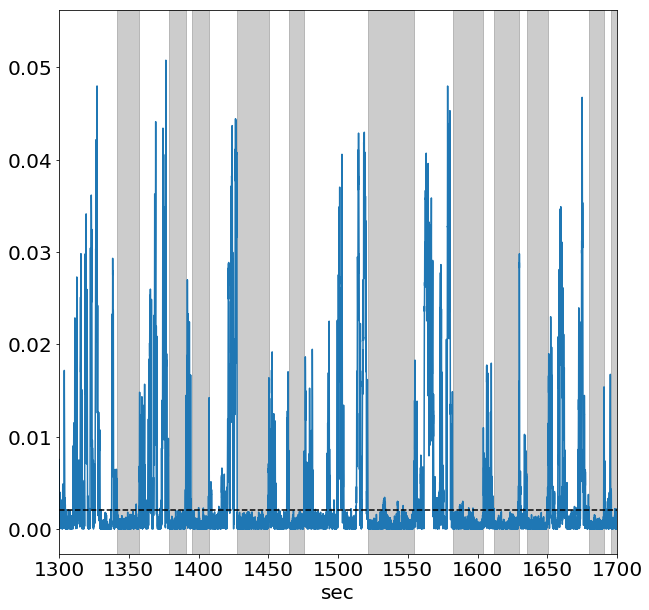

In [140]:
plt.figure(figsize=(10,10))

plt.plot(xnew/1000, fictrac_interp)
#plt.plot(xnew/1000,PB_signal_highres/10)

for bout in filtered_quiescence:
    try:
        plt.axvspan(bout['start']/100, bout['end']/100, alpha=0.2, color='k')
    except:
        pass
    
plt.axhline(B_THRESHOLD,color='k',linestyle='--')
plt.xlim(1300,1700)
plt.xlabel('sec')
#plt.xlim(808,1000)

### go from quiescence times, to neural data points

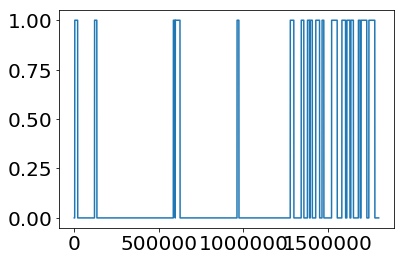

In [165]:
# turn quiescence in a 0/1 vector with ms resolution
quiescence_01 = np.zeros(expt_len)
for qui in filtered_quiescence:
    quiescence_01[qui['start']*10:qui['end']*10] = 1
plt.plot(quiescence_01)

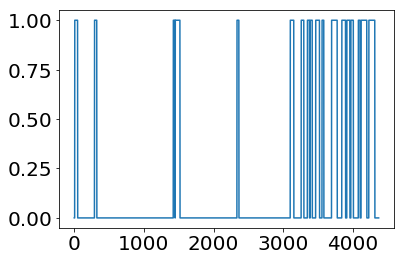

In [173]:
# for each neural point, check value of quiescence_01
qui_times = np.zeros(len(timestamps[:,25]))
for i,time in enumerate(timestamps[:,25]):
    try:
        if quiescence_01[int(round(time))] == 1:
            qui_times[i] = 1
    except IndexError:
        pass
plt.plot(qui_times)

In [256]:
filtered_bouts = [bout for bout in bouts if (bout['end']-bout['start'])/100 > 4]

In [399]:
len(bouts)

144

In [411]:
# remove bouts that have behavior too close before them
before = 3000 # in ms

before = int(before/10)
bouts=[bout for bout in BOUTS if np.mean(np.abs(fictrac_interp[bout['start']-before:bout['start']])) < .001]
print('Remaining bouts: {}'.format(np.shape(bouts)[0]))

Remaining bouts: 53


In [409]:
np.shape(BOUTS)

(144,)

In [261]:
#bout_triggered_pc_normalized = [bout-np.mean(bout[:900]) for bout in bout_triggered_pc]

In [241]:
bout_triggered_PB_array = np.asarray(bout_triggered_PB)

In [239]:
bout_triggered_pc_normalized = [bout-np.mean(bout[:900]) for bout in bout_triggered_pc]

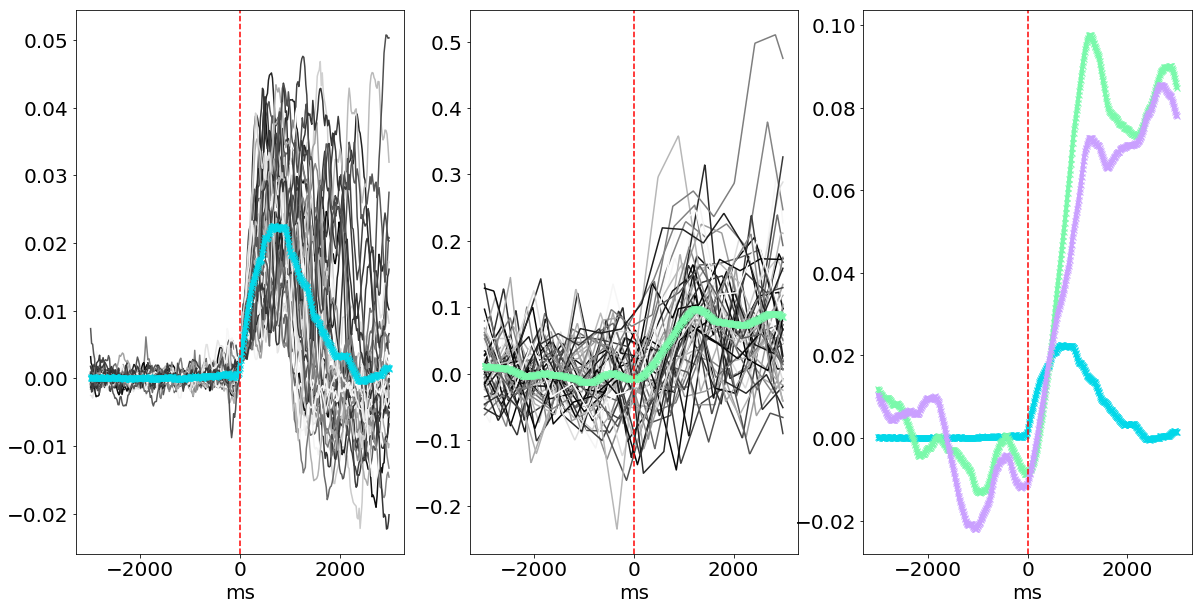

In [426]:
before = 3000 #in ms
after = 3000 # in ms

before = int(before/10) # now everything is in units of 10ms
after = int(after/10)
bins = bbb.create_bins(10,before*10,after*10)[:-1]

plt.figure(figsize=(20,10))
x=bins
plt.subplot(131)
for i,bout in enumerate(bouts):
    y=fictrac_interp[bout['start']-before:bout['start']+after]
    try:
        plt.plot(x,y,color=str(np.random.uniform()))
    except:
        print('{} Failed'.format(i))
all_bouts = [fictrac_interp[bout['start']-before:bout['start']+after] for bout in bouts][1:-1]
all_bouts = np.asarray(all_bouts)
avg_bout = np.mean(all_bouts,axis=0)
plt.plot(x,avg_bout,color='xkcd:aqua blue',linewidth=4,marker='x')
plt.axvline(0,linestyle='--',color='r')
plt.xlabel('ms')
#plt.xlim(-300,300)

xnew = np.arange(0,expt_len,resolution)
out = interp1d(timestamps[:,25], PB_R_signal, bounds_error = False)
PB_R_signal_highres = out(xnew)
out = interp1d(timestamps[:,25], PB_L_signal, bounds_error = False)
PB_L_signal_highres = out(xnew)

bout_triggered_PB_R = [PB_R_signal_highres[bout['start']-before:bout['start']+after] for bout in bouts][1:-1]
#bout_triggered_PB_R_normalized=bout_triggered_PB_R
bout_triggered_PB_R_normalized = [(bout-np.mean(bout[:200]))/np.mean(bout[:200]) for bout in bout_triggered_PB_R]
avg_PB_R = np.mean(bout_triggered_PB_R_normalized,axis=0)

bout_triggered_PB_L = [PB_L_signal_highres[bout['start']-before:bout['start']+after] for bout in bouts][1:-1]
#bout_triggered_PB_L=bout_triggered_PB_L_normalized
bout_triggered_PB_L_normalized = [(bout-np.mean(bout[:200]))/np.mean(bout[:200]) for bout in bout_triggered_PB_L]
avg_PB_L = np.mean(bout_triggered_PB_L_normalized,axis=0)

plt.subplot(132)
for i in range(len(PB_R_signal)):
    try:
        plt.plot(bins,bout_triggered_PB_R_normalized[i],color=str(np.random.uniform()))
    except:
        pass
plt.plot(x,avg_PB_R,color='xkcd:seafoam green',linewidth=4,marker='x')
plt.axvline(0,linestyle='--',color='r')
plt.xlabel('ms')
#plt.xlim(-300,300)

plt.subplot(133)
plt.plot(x,avg_bout,color='xkcd:aqua blue',linewidth=4,marker='x')
plt.plot(x,avg_PB_R,color='xkcd:seafoam green',linewidth=4,marker='x')
plt.plot(x,avg_PB_L,color='xkcd:pastel purple',linewidth=4,marker='x')

plt.axvline(0,linestyle='--',color='r')
plt.xlabel('ms')
#plt.xlim(-300,300)
#plt.ylim(-.03,0.20)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr + '.png')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

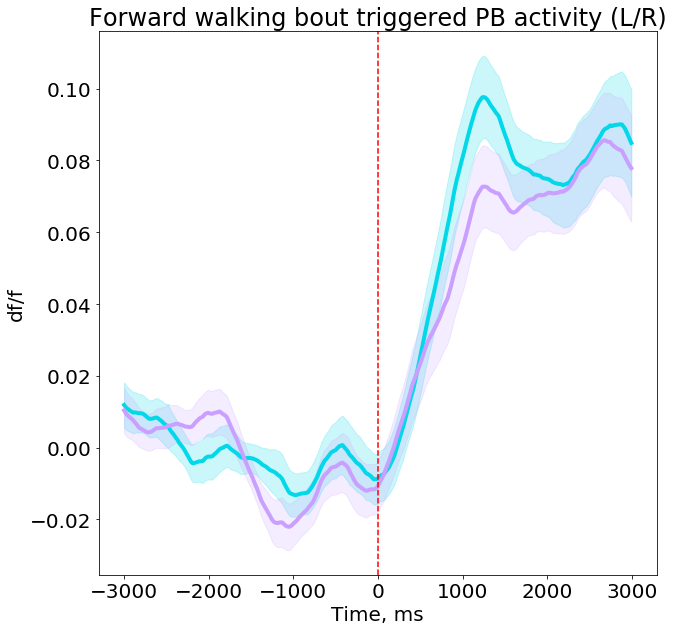

In [452]:
plt.figure(figsize=(10,10))
plt.plot(x,avg_PB_R,color='xkcd:aqua blue',linewidth=4)
plt.fill_between(x, avg_PB_R-out, avg_PB_R+out,color='xkcd:aqua blue',alpha=.2)

plt.plot(x,avg_PB_L,color='xkcd:pastel purple',linewidth=4)
plt.fill_between(x, avg_PB_L-out, avg_PB_L+out,color='xkcd:pastel purple',alpha=.2)

plt.axvline(0,linestyle='--',color='r')
plt.ylabel('df/f')
plt.xlabel('Time, ms')
plt.title('Forward walking bout triggered PB activity (L/R)')
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr + '.png')
plt.savefig(fname,dpi=300,bbox_inches='tight')

In [428]:
np.shape(bout_triggered_PB_R_normalized)

(51, 600)

In [435]:
R_error=scipy.stats.sem(bout_triggered_PB_R_normalized)
L_error=scipy.stats.sem(bout_triggered_PB_L_normalized)

In [430]:
out.shape

(600,)

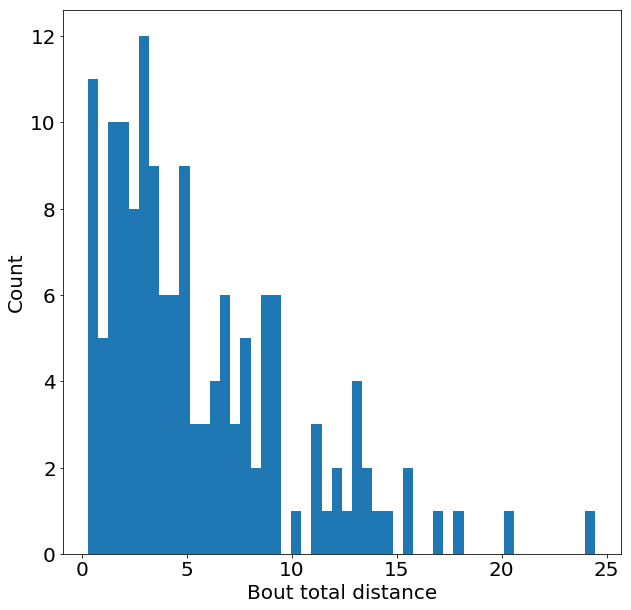

In [219]:
plt.figure(figsize=(10,10))
plt.hist([np.sum(fictrac_interp[bout['start']:bout['end']]) for bout in bouts], bins=50);
plt.xlabel('Bout total distance')
plt.ylabel('Count')
save_path = os.path.join(directory, '20190807_figs')
#fname = os.path.join(save_path, 'bout total distance hist')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [221]:
bouts[-1]

{'end': 178854, 'start': 177722}

Text(0, 0.5, 'Count')

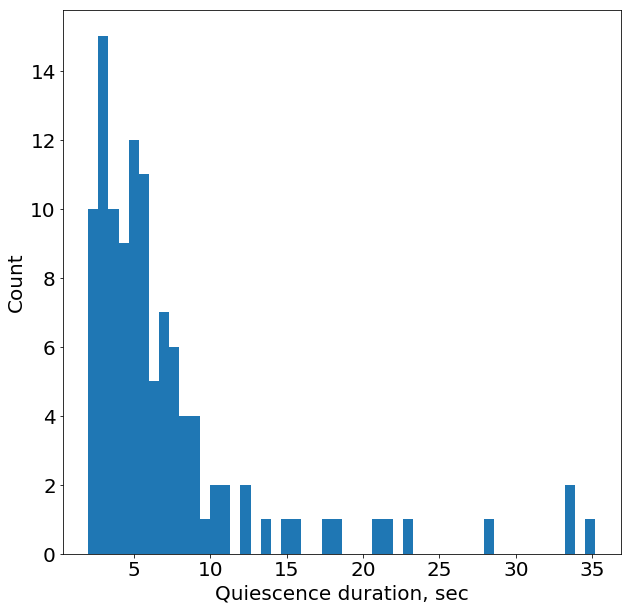

In [115]:
plt.figure(figsize=(10,10))
plt.hist([(bout['end']-bout['start'])/100 for bout in quiescence], bins=50);
plt.xlabel('Quiescence duration, sec')
plt.ylabel('Count')
#save_path = os.path.join(directory, '20190807_figs')
#fname = os.path.join(save_path, 'bout duration hist')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(xnew/1000, fictrac_interp)
plt.plot(xnew/1000,PB_signal_highres/10)

for bout in bouts:
    try:
        plt.axvspan(bout['start']/100, bout['end']/100, alpha=0.2, color='k')
        plt.axvline(bout['start']/100,color='r',linestyle='--')
    except:
        pass

plt.axhline(B_THRESHOLD,color='k',linestyle='--')
plt.xlim(1450,1800)
#plt.xlim(808,1000)

# Rotation

(120000, 160000)

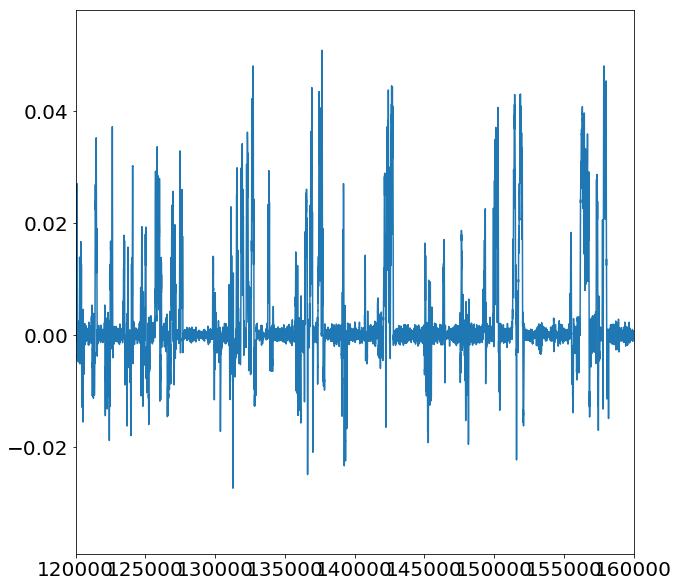

In [355]:
plt.figure(figsize=(10,10))
plt.plot(fictrac_interp)
plt.xlim(120000,160000)